<a href="https://colab.research.google.com/github/qri0usmind/Equity-Research---Bajaj-Auto/blob/main/BajajAuto_Sentiment_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
from datetime import datetime, timedelta

def scrape_headlines(days=60):
    headlines = []
    dates = []
    base_url = "https://economictimes.indiatimes.com/bajaj-auto-ltd/stocksupdate/companyid-21430.cms"

    for i in range(days):
        scrape_date = datetime.now() - timedelta(days=i)
        formatted_scrape_date = scrape_date.strftime('%d-%m-%Y')
        url = f"{base_url}?date={formatted_scrape_date}"

        response = requests.get(url)
        soup = BeautifulSoup(response.content, 'html.parser')

        for article in soup.find_all('div', class_='eachStory'):
            headline = article.find('h3').text.strip()

            # Extract and parse the date from the article, if available
            date_element = article.find('time')
            if date_element and date_element.get('datetime'):
                article_date = datetime.strptime(date_element['datetime'], '%Y-%m-%d %H:%M:%S')
            else:
                # If no specific date found, use the scrape date
                article_date = scrape_date

            # Format the date consistently
            formatted_date = article_date.strftime('%Y-%m-%d')

            headlines.append(headline)
            dates.append(formatted_date)

    df = pd.DataFrame({'Date': dates, 'Headline': headlines})
    return df

# Scrape headlines for the last 30 days
headlines_df = scrape_headlines(60)

# Sort the dataframe by date
headlines_df['Date'] = pd.to_datetime(headlines_df['Date'])
headlines_df = headlines_df.sort_values('Date')

# Save to CSV
headlines_df.to_csv('bajaj_auto_headlines.csv', index=False)
print("Headlines saved to bajaj_auto_headlines.csv")

Headlines saved to bajaj_auto_headlines.csv


In [ ]:
import yfinance as yf
import pandas as pd
from datetime import datetime, timedelta

def fetch_stock_data(symbol, days=60):
    end_date = datetime.now()
    start_date = end_date - timedelta(days=days)

    stock = yf.Ticker(symbol)
    data = stock.history(start=start_date, end=end_date)

    # Calculate daily price change
    data['Price_Change'] = data['Close'].pct_change()

    # Convert to binary (1 for increase, 0 for decrease or no change)
    data['Stock_Movement'] = (data['Price_Change'] > 0).astype(int)

    # Reset index to make Date a column
    data = data.reset_index()

    # Format the date consistently
    data['Date'] = data['Date'].dt.strftime('%Y-%m-%d')

    # Keep only Date and Stock_Movement columns
    data = data[['Date', 'Stock_Movement']]

    return data

# Fetch Bajaj Auto stock data (adjust the symbol if needed)
stock_data = fetch_stock_data("BAJAJ-AUTO.NS", 60)

# Save to CSV
stock_data.to_csv('bajaj_auto_stock_movement.csv', index=False)
print("Stock data saved to bajaj_auto_stock_movement.csv")

Stock data saved to bajaj_auto_stock_movement.csv


In [ ]:
import pandas as pd
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import string

# Download necessary NLTK data
nltk.download('punkt')
nltk.download('stopwords')

def preprocess_data(headlines_file, stock_file):
    # Load data
    headlines_df = pd.read_csv(headlines_file)
    stock_df = pd.read_csv(stock_file)

    # Merge dataframes
    df = pd.merge(headlines_df, stock_df, on='Date', how='inner')

    # Preprocess headlines
    def clean_text(text):
        # Convert to lowercase
        text = text.lower()
        # Remove punctuation
        text = text.translate(str.maketrans('', '', string.punctuation))
        # Tokenize
        tokens = word_tokenize(text)
        # Remove stopwords
        stop_words = set(stopwords.words('english'))
        tokens = [word for word in tokens if word not in stop_words]
        return ' '.join(tokens)

    df['Cleaned_Headline'] = df['Headline'].apply(clean_text)

    return df

# Use the function
processed_df = preprocess_data('bajaj_auto_headlines.csv', 'bajaj_auto_stock_movement.csv')
processed_df.to_csv('processed_data.csv', index=False)
print("Processed data saved to processed_data.csv")

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


Processed data saved to processed_data.csv


In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np

def extract_features(data_file, max_features=1000):
    # Load processed data
    df = pd.read_csv(data_file)

    # Create Bag-of-Words representation
    vectorizer = CountVectorizer(max_features=max_features)
    bow_matrix = vectorizer.fit_transform(df['Cleaned_Headline'])

    # Convert to DataFrame
    bow_df = pd.DataFrame(bow_matrix.toarray(), columns=vectorizer.get_feature_names_out())

    # Combine with stock movement
    final_df = pd.concat([bow_df, df['Stock_Movement']], axis=1)

    # Split into training and testing sets
    X = final_df.drop('Stock_Movement', axis=1)
    y = final_df['Stock_Movement']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    return X_train, X_test, y_train, y_test, vectorizer

# Use the function
X_train, X_test, y_train, y_test, vectorizer = extract_features('processed_data.csv')

print("Feature extraction completed.")
print(f"Training set shape: {X_train.shape}")
print(f"Testing set shape: {X_test.shape}")

# Save the vectorizer for later use
import joblib
joblib.dump(vectorizer, 'bow_vectorizer.joblib')
print("Vectorizer saved as bow_vectorizer.joblib")

Feature extraction completed.
Training set shape: (1312, 204)
Testing set shape: (328, 204)
Vectorizer saved as bow_vectorizer.joblib


[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


Sentiment analysis completed. Results saved to sentiment_analyzed_data.csv
Sentiment distribution plot saved as sentiment_distribution.png
         Date                                   Cleaned_Headline  Sentiment  \
0  2024-07-22  nifty could move towards 25600 technical analysts     0.4019   
1  2024-07-22  bajaj auto announcement regulation 30 securiti...     0.2960   
2  2024-07-22  market wrap investors cautious ahead powell sp...     0.5719   
3  2024-07-22  technical view decisive moveup could take nift...     0.5574   
4  2024-07-22  bajaj auto intimation regulation 30 securities...     0.2960   

  Sentiment_Category  Stock_Movement  
0           Positive               0  
1           Positive               0  
2           Positive               0  
3           Positive               0  
4           Positive               0  


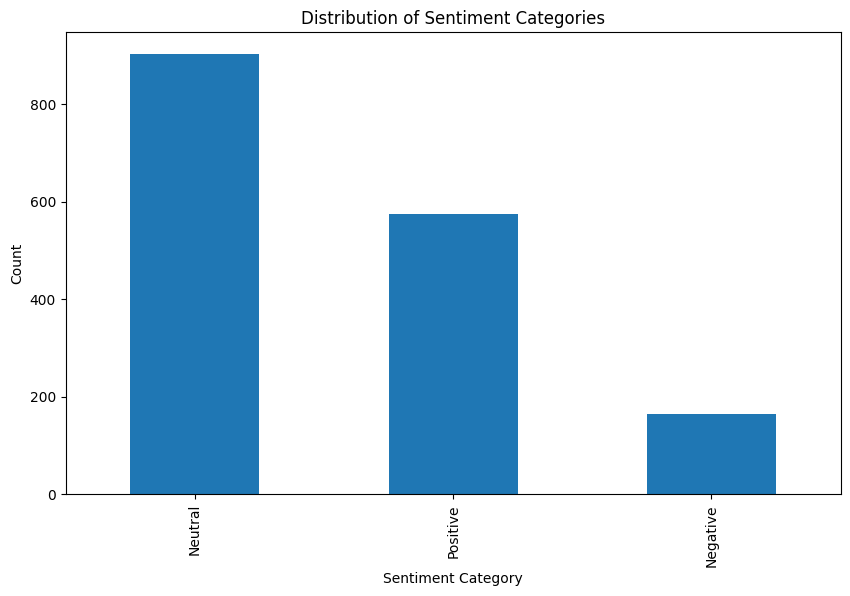

In [ ]:
import pandas as pd
import nltk
from nltk.sentiment import SentimentIntensityAnalyzer
import matplotlib.pyplot as plt

# Download necessary NLTK data
nltk.download('vader_lexicon')

def analyze_sentiment(data_file):
    # Load processed data
    df = pd.read_csv(data_file)

    # Initialize VADER sentiment analyzer
    sia = SentimentIntensityAnalyzer()

    # Perform sentiment analysis
    df['Sentiment_Scores'] = df['Cleaned_Headline'].apply(lambda x: sia.polarity_scores(x))
    df['Sentiment'] = df['Sentiment_Scores'].apply(lambda x: x['compound'])

    # Categorize sentiment
    df['Sentiment_Category'] = df['Sentiment'].apply(lambda x: 'Positive' if x > 0 else ('Negative' if x < 0 else 'Neutral'))

    # Save results
    df.to_csv('sentiment_analyzed_data.csv', index=False)
    print("Sentiment analysis completed. Results saved to sentiment_analyzed_data.csv")

    # Visualize sentiment distribution
    plt.figure(figsize=(10, 6))
    df['Sentiment_Category'].value_counts().plot(kind='bar')
    plt.title('Distribution of Sentiment Categories')
    plt.xlabel('Sentiment Category')
    plt.ylabel('Count')
    plt.savefig('sentiment_distribution.png')
    print("Sentiment distribution plot saved as sentiment_distribution.png")

    return df

# Use the function
sentiment_df = analyze_sentiment('processed_data.csv')
print(sentiment_df[['Date', 'Cleaned_Headline', 'Sentiment', 'Sentiment_Category', 'Stock_Movement']].head())

Correlation between Sentiment and Stock Movement: 1.0727609322489785e-17
T-statistic: 0.0, p-value: 1.0
Visualization saved as sentiment_vs_stock_movement.png

Top 10 words with highest impact on sentiment:
strong: 0.6035461538461538
25000: 0.6035461538461538
momentum: 0.6035461538461538
emerge: 0.5849820512820512
ecosystem: 0.5849820512820512
winners: 0.5849820512820512
ev: 0.5849820512820512
ancillary: 0.5849820512820512
clarity: 0.5849820512820512
past: 0.534692105263158


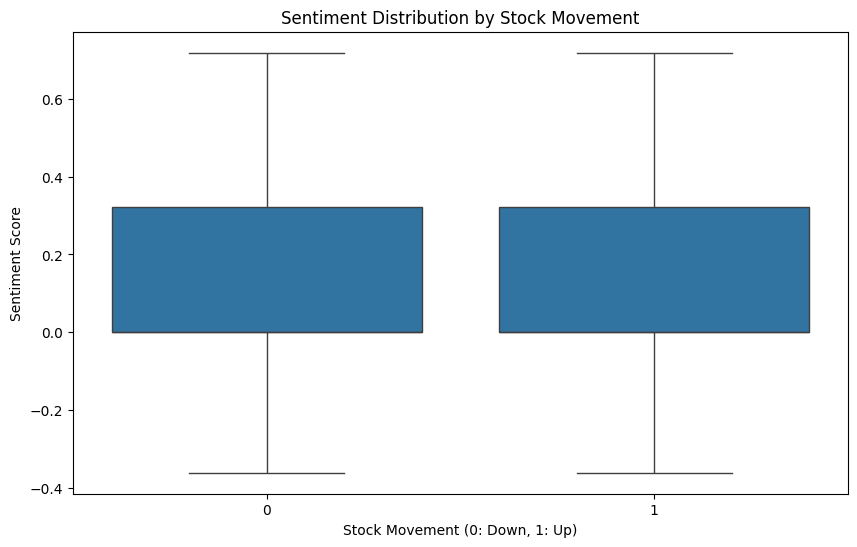

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

def analyze_correlation(data_file):
    # Load sentiment analyzed data
    df = pd.read_csv(data_file)

    # Calculate correlation
    correlation = df['Sentiment'].corr(df['Stock_Movement'])
    print(f"Correlation between Sentiment and Stock Movement: {correlation}")

    # Perform t-test
    t_stat, p_value = stats.ttest_ind(df[df['Stock_Movement'] == 1]['Sentiment'],
                                      df[df['Stock_Movement'] == 0]['Sentiment'])
    print(f"T-statistic: {t_stat}, p-value: {p_value}")

    # Visualize relationship
    plt.figure(figsize=(10, 6))
    sns.boxplot(x='Stock_Movement', y='Sentiment', data=df)
    plt.title('Sentiment Distribution by Stock Movement')
    plt.xlabel('Stock Movement (0: Down, 1: Up)')
    plt.ylabel('Sentiment Score')
    plt.savefig('sentiment_vs_stock_movement.png')
    print("Visualization saved as sentiment_vs_stock_movement.png")

    # Analyze impact of specific words
    word_impact = {}
    for word in set(' '.join(df['Cleaned_Headline']).split()):
        word_present = df['Cleaned_Headline'].str.contains(word)
        if word_present.sum() > 5:  # Only consider words that appear in more than 5 headlines
            avg_sentiment_with_word = df[word_present]['Sentiment'].mean()
            avg_sentiment_without_word = df[~word_present]['Sentiment'].mean()
            word_impact[word] = avg_sentiment_with_word - avg_sentiment_without_word

    # Sort words by impact
    sorted_words = sorted(word_impact.items(), key=lambda x: abs(x[1]), reverse=True)

    print("\nTop 10 words with highest impact on sentiment:")
    for word, impact in sorted_words[:10]:
        print(f"{word}: {impact}")

    return df, word_impact

# Use the function
analyzed_df, word_impact = analyze_correlation('sentiment_analyzed_data.csv')